<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Gustavo_Arantes/prj_final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IAE025-A - Introdução ao Aprendizado Profundo
# Projeto Final - Image Captioning
# Aluno: Gustavo da Silva Arantes


# 1. Setup

In [2]:
!pip install transformers sentencepiece efficientnet_pytorch sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 57.7 MB/s 
     |████████████████████████████████| 92 kB 13.2 MB/s 
     |████████████████████████████████| 101 kB 14.5 MB/s 
     |████████████████████████████████| 596 kB 86.8 MB/s 
     |████████████████████████████████| 6.6 MB 58.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=89969cddcb9e62a702827f05cfbf91f9e026297a49222677b71375790db339de
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# sementes
import numpy as np
import random
import torch

seed = 14
random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
# download das bases
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5

--2022-07-20 20:49:49--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289777 (283K) [application/json]
Saving to: ‘TEST_CAPTIONS_coco_5_cap_per_img.json’

TEST_CAPTIONS_coco_ 100%[===================>] 282.99K  --.-KB/s    in 0.002s  

2022-07-20 20:49:49 (150 MB/s) - ‘TEST_CAPTIONS_coco_5_cap_per_img.json’ saved [289777/289777]

--2022-07-20 20:49:49--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, 

In [6]:
# organização dos datasets
import json
import h5py

# imagens
train_image_path = 'TRAIN_IMAGES_coco_5_cap_per_img.hdf5'
valid_image_path = 'VAL_IMAGES_coco_5_cap_per_img.hdf5'
teste_image_path = 'TEST_IMAGES_coco_5_cap_per_img.hdf5'
print('Imagens - treino:', h5py.File(train_image_path, 'r')['images'].shape[0])
print('Imagens - validação:', h5py.File(valid_image_path, 'r')['images'].shape[0])
print('Imagens - teste:', h5py.File(teste_image_path,'r')['images'].shape[0])
print()

# legendas
train_captions_path = 'TRAIN_CAPTIONS_coco_5_cap_per_img.json'
valid_captions_path = 'VAL_CAPTIONS_coco_5_cap_per_img.json'
teste_captions_path = 'TEST_CAPTIONS_coco_5_cap_per_img.json'
print('Legendas - treino:', len(json.load(open(train_captions_path, 'r'))))
print('Legendas - validação:', len(json.load(open(valid_captions_path,   'r'))))
print('Legendas - teste:', len(json.load(open(teste_captions_path,  'r'))))

Imagens - treino: 23520
Imagens - validação: 1052
Imagens - teste: 1047

Legendas - treino: 23520
Legendas - validação: 1052
Legendas - teste: 1047


In [7]:
# dimensões das imagens
h5py.File(train_image_path, 'r')['images'].shape

(23520, 3, 256, 256)

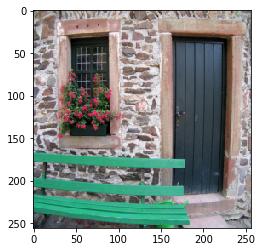

In [8]:
# exemplos de imagens
from matplotlib import pyplot as plt
plt.imshow(h5py.File(train_image_path, 'r')['images'][15].transpose(1, 2, 0), interpolation='nearest')
plt.show()

In [9]:
# exemplos das legendas
json.load(open(train_captions_path, 'r'))[15]

['The front of a small cabin with a window garden and green bench.',
 'A wooden bench sitting next to an entrance.',
 'A green bench in front of a window box',
 'A green wooden bench in front of a house.',
 'a green, warped bench outside of a small cottage with a flowers in the window']

# 2. DataLoader e Dataset

In [10]:
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-small', model_max_length=32)

class MyDataSet(Dataset):
  """
  Classe para leitura das imagens e com uma das 5 legendas amostradas de maneira aleatória.
  Nesta classe as legendas já são transformadas em tokens
  """

  def __init__(self, image_file, caption_file, tokenizer): 
    self.image_file = image_file
    self.images = h5py.File(self.image_file, 'r') 
    
    self.captions = json.load(open(caption_file, "r"))

  def __len__(self):
    return len(self.captions)

  def __getitem__(self, index):
    imagem = self.images['images'][index]
    legenda = random.choice(self.captions[index])

    tokens = tokenizer(legenda, return_tensors='pt', max_length=32, padding='max_length', truncation=True)
            
    return imagem, legenda, tokens['input_ids']

train_set = MyDataSet(train_image_path, train_captions_path, tokenizer) 
valid_set = MyDataSet(valid_image_path, valid_captions_path, tokenizer)
teste_set = MyDataSet(teste_image_path, teste_captions_path, tokenizer)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

## 2.1 - Testando as estruturas criadas

In [11]:
# data loader
import multiprocessing as mp
train_loader = DataLoader(
    train_set,
    batch_size=5,
    num_workers=mp.cpu_count()
)

dataloader_val = DataLoader(
    valid_set,
    batch_size=5,
    num_workers=mp.cpu_count()
)

dataloader_teste = DataLoader(
    teste_set,
    batch_size=5,
    num_workers=mp.cpu_count()
)

torch.Size([5, 3, 256, 256])


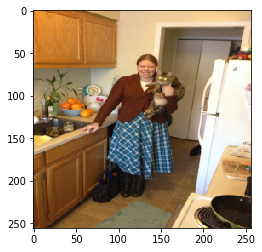

A woman is working in a kitchen carrying a soft toy.


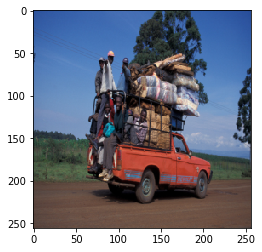

A truck with a number of people and things in the back


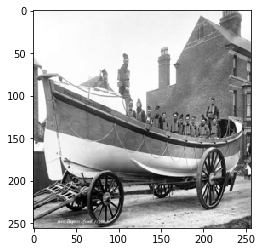

A bunch of people aboard a boat with wheels. 


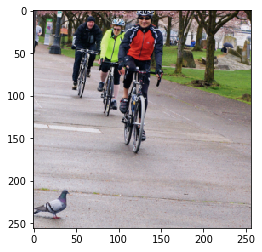

A geoup of people on bicycles coming down a street.


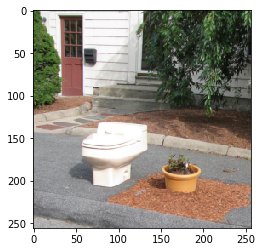

A toilet is sitting on the ground next to a plant.


In [12]:
# imagens e legenda
print(next(iter(train_loader))[0].shape)
examples = next(iter(train_loader))
for i in range(0,5):
  plt.imshow(examples[0][i].numpy().transpose(1, 2, 0), interpolation='nearest')
  plt.show()
  print(examples[1][i])

In [13]:
# tokens
print(examples[2].shape)
examples[2]

torch.Size([5, 1, 32])


tensor([[[   71,  2335,    19,   464,    16,     3,     9,  1228,  6771,     3,
              9,  1835,    12,    63,     5,     1,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]],

        [[   71,  4072,    28,     3,     9,   381,    13,   151,    11,   378,
             16,     8,   223,     1,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]],

        [[   71,  7292,    13,   151, 21392,     3,     9,  3432,    28,  8277,
              5,     1,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]],

        [[   71,  9502,   413,    13,   151,    30, 12679,     7,  1107,   323,
              3,     9,  2815,     5,     1,     0,     0,     0,     0,     0,
              0,     0,     0,     0,  

# 3. Treino

## 3.1 Modelo Dummy

In [17]:
from torch import nn
from torch import Tensor
from transformers import T5ForConditionalGeneration
from efficientnet_pytorch import EfficientNet

class CaptionModel(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.decoder = T5ForConditionalGeneration.from_pretrained('t5-small')

    self.encoder = nn.Conv2d(3, self.decoder.config.d_model, (16, 16), stride=16)
    # kernel conv 2d, 3 canais, saída da camada conv é igual tam entra do T5, 16x16 tamanho do kernel, 

  def forward(self, img, labels = None):
    # processar imagem
    img = img.float() #batch_sizex3x256x256
    img_features = self.encoder(img) #batch_sizex512x16x16
    img_features = img_features.reshape(img_features.shape[0], self.decoder.config.d_model, -1) #batch_sizex512x256
    img_features = img_features.permute(0, 2, 1) #batch_sizex256x512
    
    if labels is not None:
        labels = labels.reshape(img_features.shape[0], -1)

    if labels is None:
      encoder_out = self.decoder.encoder(inputs_embeds = img_features)
      predict_tokens = self.decoder.generate(encoder_outputs = encoder_out, max_length = 32)
      return predict_tokens
    else:
      loss = self.decoder(inputs_embeds=img_features, labels=labels)[0] 
      return loss


In [18]:
# função de treino
from tqdm import tqdm
device = 'cuda:0'

# apoio colega
def train(model, device, dataloader, optimizer):

  model.train()

  train_batch = tqdm(dataloader, total=len(dataloader))
  batch_loss = 0.0
  
  for imgs, _, label_tokens  in train_batch:
    inputs = imgs.to(device)
    labels = label_tokens.to(device)

    # zerar informação do otimizador
    optimizer.zero_grad()

    # calcular loss de treino
    loss = model(inputs, labels)

    # gradiente do treino
    loss.backward()
    optimizer.step()

    # loss do batch
    batch_loss += loss.item()

  # loss após o batch
  epoch_train_loss = batch_loss/len(train_batch)

  return epoch_train_loss

In [19]:
# função de validação
def val(model, device, dataloader):
  
  # definir o modelo para validação
  model.eval()

  val_batch = tqdm(dataloader, total=len(dataloader))
  val_loss = 0.0

  for imgs, _, label_tokens in val_batch:
    inputs = imgs.to(device)
    labels = label_tokens.to(device)

    # loss de validação
    loss = model(inputs, labels)

    # loss do batch
    val_loss += loss.item()

  epoch_val_loss = val_loss/len(val_batch)  
  return epoch_val_loss

In [20]:
model = CaptionModel()
model = model.to(device)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100
 
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
  train_loss = train(model, device, train_loader, optimizer)
  train_loss_history.append(train_loss)

  val_loss = val(model, device, dataloader_val)
  val_loss_history.append(val_loss)

  print('Epoch %d - Train Loss %.5f - Validation Loss %.5f' 
        %(epoch, train_loss, val_loss))

  if epoch%10==0:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, '/content/drive/MyDrive/project/model_01/model_dummy.pt')

  1%|          | 24/4704 [00:08<27:28,  2.84it/s]


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd

dict_scores = {
    'epocas': range(epochs),
    'treino': train_loss_history,
    'valid': val_loss_history
}

df = pd.DataFrame(dict_scores)
df.to_csv('model_dummy_final.csv', index=False)

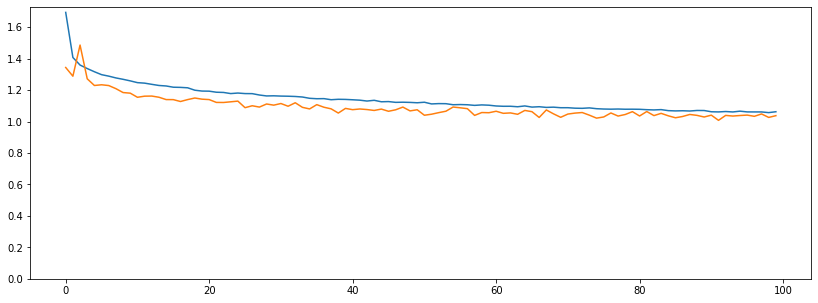

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14,5))

train_loss_history
val_loss_history

plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='valid')

plt.ylim((0,None))

plt.show()



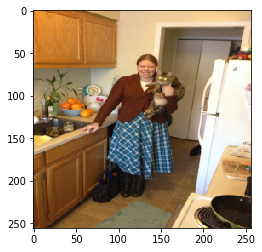

real: A woman is working in a kitchen carrying a soft toy.
predito: A large large a large large a large a large a large large a large a large large a large large large


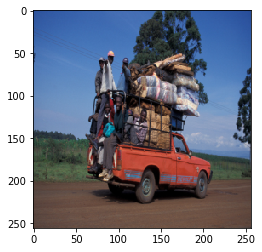

real: A truck with a number of people and things in the back
predito: 


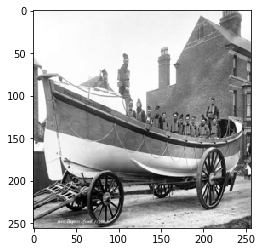

real: A bunch of people aboard a boat with wheels. 
predito: A     A a sa


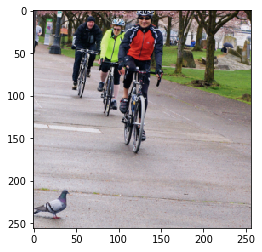

real: A geoup of people on bicycles coming down a street.
predito: A a


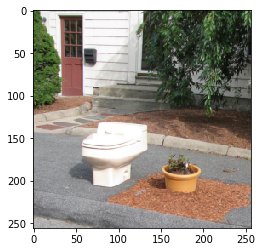

real: A toilet is sitting on the ground next to a plant.
predito: Aside aside a sac.


In [18]:
predict = tokenizer.batch_decode(model(examples[0].to(device)), skip_special_tokens=True)
for i in range(0,5):
  plt.imshow(examples[0][i].numpy().transpose(1, 2, 0), interpolation='nearest')
  plt.show()
  print('real:', examples[1][i])
  print('predito:', predict[i])

### 3.1.1 Teste

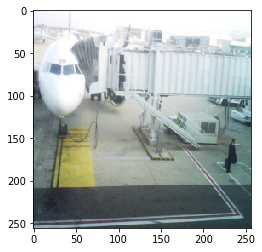

real: The plane is parked at the gate at the airport terminal.
predito: A large passenger jet sitting on top of an airport tarmac.


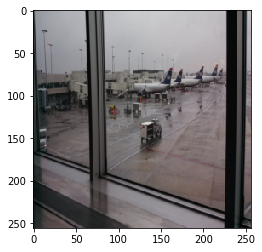

real: The view of runway from behind the windows of airport.
predito: A man standing next to a truck with a dog on it.


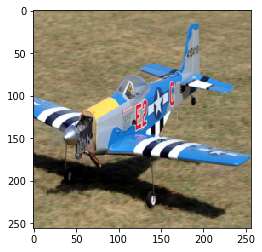

real: A small blue plane sitting on top of a field.
predito: A cat is sitting on a laptop computer.


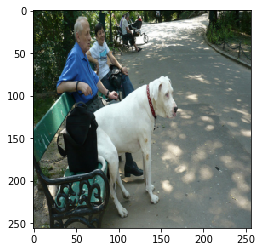

real: A large white dog sits on a bench with people next to a path.
predito: A man is standing in front of a car.


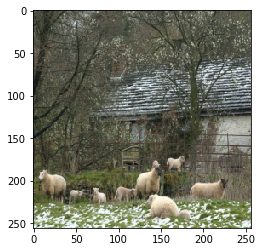

real: Several sheep grazing in a field of tall grass in front of a building.
predito: A giraffe standing next to a tree in a field.


In [ ]:
predict = tokenizer.batch_decode(model_dummie(examples[0].to(device)), skip_special_tokens=True)
for i in range(0,5):
  plt.imshow(examples[0][i].numpy().transpose(1, 2, 0), interpolation='nearest')
  plt.show()
  print('real:', examples[1][i])
  print('predito:', predict[i])

### 3.1.2 Bleu

In [ ]:
import sacrebleu
model_dummie = CaptionModel()
model_dummie = model_dummie.to(device)
learning_rate = 1e-5

checkpoint = torch.load('/content/drive/MyDrive/project/model_01/model_dummie_final.pt')
model_dummie.load_state_dict(checkpoint['model_state_dict'])

model_dummie.eval()

teste_batch = tqdm(dataloader_teste, total=len(dataloader_teste))

label_predict = []
label_target = []

for imgs, label_true, label_tokens in teste_batch:
  inputs = imgs.to(device)
  labels = label_tokens.to(device)

  predict = model(inputs)

  predict_batch = [tokenizer.decode(x, skip_special_tokens=True) for x in predict]

  label_predict += predict_batch
  label_target += label_true


bleu = 0.0

for pred, true in zip(label_predict, label_target):
  bleu_score = sacrebleu.corpus_bleu(pred, true)
  bleu += bleu_score.precisions[0]

print(f'BLEU_1: {bleu/len(label_predict)}')

100%|██████████| 210/210 [00:41<00:00,  5.04it/s]


BLEU_1: 65.61604584527221


## 3.2 Modelo Otimizado

In [21]:
class EfficientCaptionModel(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.decoder = T5ForConditionalGeneration.from_pretrained('t5-small')

    self.encoder = EfficientNet.from_pretrained('efficientnet-b0', advprop=False)

    for param in self.encoder.parameters():
        param.requires_grad = False

    # dimensão dos embeddings da imagem
    feature_dim = list(self.encoder.named_parameters())[-2][1].shape[1]

    # reshape dos embeddings
    self.featuremap_adapter = nn.Conv2d(in_channels=feature_dim, out_channels=self.decoder.config.d_model, kernel_size=1)

  def forward(self, img, labels = None):
    # processar imagem
    img = img.float() # batch_sizex3x256x256
    img_features = self.encoder.extract_features(img) # batch_sizex1280x8x8
    img_features = self.featuremap_adapter(img_features) # batch_sizex512x8x8
    img_features = img_features.reshape(img_features.shape[0], self.decoder.config.d_model, -1) # batch_sizex512x64
    img_features = img_features.permute(0, 2, 1) # batch_sizex64x512
    
    if labels is not None:
      labels = labels.reshape(img_features.shape[0], 32)

    if labels is None:
      encoder_out = self.decoder.encoder(inputs_embeds = img_features)
      predict_tokens = self.decoder.generate(encoder_outputs = encoder_out, max_length = 32)
      return predict_tokens

    else:
      loss = self.decoder(inputs_embeds=img_features, labels=labels)[0] 
      return loss


In [22]:
import pandas as pd

model = EfficientCaptionModel()
model = model.to(device)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100


 
train_loss_history = []
val_loss_history = []
epoch_history = []

for epoch in range(epochs):
  train_loss = train(model, device, train_loader, optimizer)
  train_loss_history.append(train_loss)

  val_loss = val(model, device, dataloader_val, epoch)
  val_loss_history.append(val_loss)

  print('Epoch %d - Train Loss %.5f - Validation Loss %.5f' 
        %(epoch, train_loss, val_loss))

  epoch_history.append(epoch)

  dict_scores = {
      'epocas': epoch_history,
      'treino': train_loss_history,
      'valid': val_loss_history
  }

  df = pd.DataFrame(dict_scores)
  df.to_csv('/content/drive/MyDrive/project/model_01/model_efficient_final.csv', index=False)

  if epoch%10==0:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, f'/content/drive/MyDrive/project/model_01/new_model_efficient_epoch_{epoch}.pt')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


  1%|          | 35/4704 [00:03<06:49, 11.41it/s]


KeyboardInterrupt: ignored

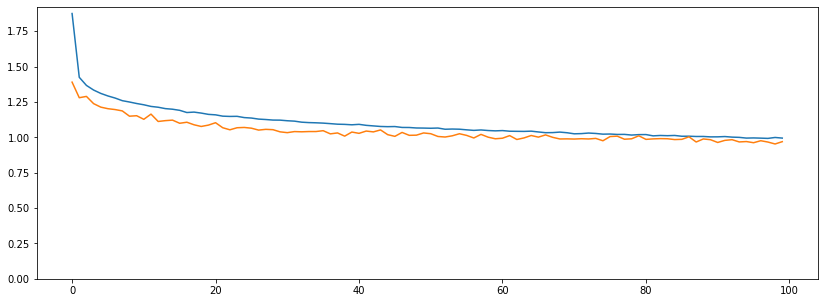

In [ ]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
        }, '/content/drive/MyDrive/project/model_01/new_model_efficient_final.pt')

dict_scores = {
    'epocas': range(epochs),
    'treino': train_loss_history,
    'valid': val_loss_history
}

df = pd.DataFrame(dict_scores)
df.to_csv('/content/drive/MyDrive/project/model_01/new_model_efficient__final.csv', index=False)

fig, ax = plt.subplots(1, 1, figsize=(14,5))

train_loss_history
val_loss_history

plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='valid')

plt.ylim((0,None))

plt.show()


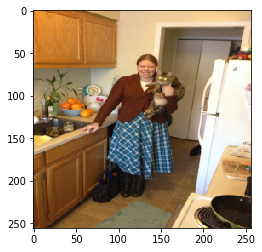

real: A woman is working in a kitchen carrying a soft toy.
predito: 


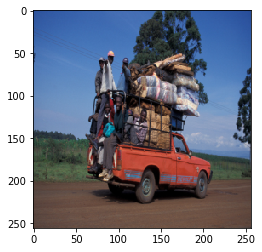

real: A truck with a number of people and things in the back
predito: 


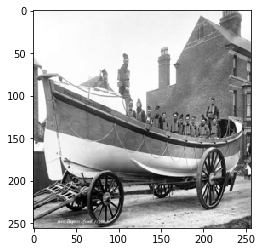

real: A bunch of people aboard a boat with wheels. 
predito: 


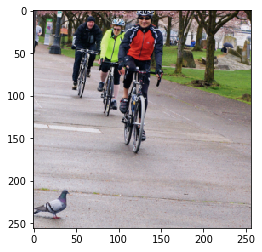

real: A geoup of people on bicycles coming down a street.
predito: ff. f. f f. f f. f. f. f. f.


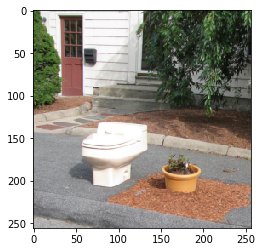

real: A toilet is sitting on the ground next to a plant.
predito: ss s sss, ss ss sss s ss ss s


In [21]:
predict = tokenizer.batch_decode(model(examples[0].to(device)), skip_special_tokens=True)
for i in range(0,5):
  plt.imshow(examples[0][i].numpy().transpose(1, 2, 0), interpolation='nearest')
  plt.show()
  print('real:', examples[1][i])
  print('predito:', predict[i])

### 3.2.1 Teste

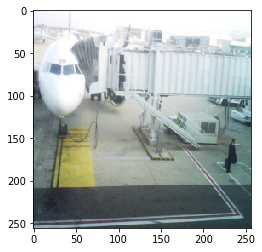

real: The plane is parked at the gate at the airport terminal.
predito: A large white airplane sitting on top of an airport tarmac.


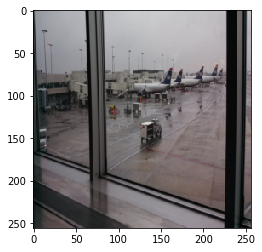

real: The view of runway from behind the windows of airport.
predito: A truck driving down a street next to a building.


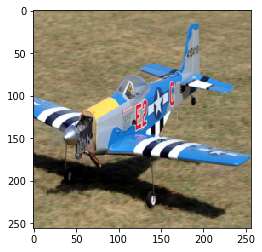

real: A small blue plane sitting on top of a field.
predito: A large jetliner flying through a blue sky.


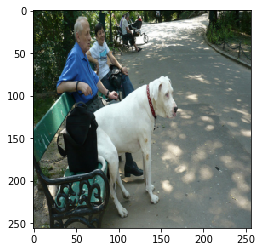

real: A large white dog sits on a bench with people next to a path.
predito: A man sitting on a bench with a dog.


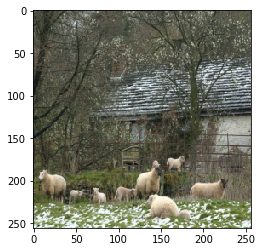

real: Several sheep grazing in a field of tall grass in front of a building.
predito: A herd of sheep standing next to a tree.


In [ ]:
predict = tokenizer.batch_decode(model(examples[0].to(device)), skip_special_tokens=True)
for i in range(0,5):
  plt.imshow(examples[0][i].numpy().transpose(1, 2, 0), interpolation='nearest')
  plt.show()
  print('real:', examples[1][i])
  print('predito:', predict[i])

### 3.2.2 Bleu

In [24]:
import sacrebleu
model = EfficientCaptionModel()
model = model.to(device)
learning_rate = 1e-5

checkpoint = torch.load('/content/drive/MyDrive/project/model_01/new_model_efficient_final.pt')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

teste_batch = tqdm(dataloader_teste, total=len(dataloader_teste))

label_predict = []
label_target = []

for imgs, label_true, label_tokens in teste_batch:
  inputs = imgs.to(device)
  labels = label_tokens.to(device)

  predict = model(inputs)

  predict_batch = [tokenizer.decode(x, skip_special_tokens=True) for x in predict]

  label_predict += predict_batch
  label_target += label_true


bleu = 0.0

for pred, true in zip(label_predict, label_target):
  bleu_score = sacrebleu.corpus_bleu(pred, true)
  bleu += bleu_score.precisions[0]

print(f'BLEU_1: {bleu/len(label_predict)}')


Loaded pretrained weights for efficientnet-b0


100%|██████████| 210/210 [00:43<00:00,  4.79it/s]


BLEU_1: 62.27316141356256
